In [55]:
import torch
import torch.nn as nn
import matplotlib
from dataloader import DataLoader

In [56]:
IMG_DIM = 28
MNIST_PATH = r"/home/anton/KTH/year5/5LSH0/mnist"
EPOCHS = 50
BATCH_SIZE = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
CORRUPT_DATA = None

In [57]:
class Autoencoder(nn.Module):
    def __init__(self, ):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(IMG_DIM * IMG_DIM, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, IMG_DIM * IMG_DIM),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded)
        return decoded


In [58]:
""" 
Code taken from: https://stackoverflow.com/questions/53956932/use-pytorch-ssim-loss-function-in-my-model
creaete SSIMLoss class
"""
from piqa import SSIM
class SSIMLoss(SSIM):
    def forward(self, x, y):
        x = x.reshape(x.size(0), 1, IMG_DIM, IMG_DIM)
        y = y.reshape(y.size(0), 1, IMG_DIM, IMG_DIM)
        # Convert inte rbg, beacause SSIM requires it, grayscale to RGB: R = G = B = grayscale value 
        x = x.repeat(1,3,1,1) 
        y = y.repeat(1,3,1,1) 
        return 1. - super().forward(x, y)

In [59]:
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import time

model = Autoencoder()
criterion = SSIMLoss()
# criterion = nn.MSELoss() 
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    # weight_decay=WEIGHT_DECAY,
)
writer = SummaryWriter()

def train(loader, epochs):
    

    tic = time.perf_counter()

    for epoch in range(1, epochs+1):
        loss = 0
        for _, (image, _) in enumerate(loader):
            image = image.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(image)
            loss = criterion(reconstructed_image, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss += loss.item() 

        toc = time.perf_counter()
        time_format = time.strftime("%M:%S", time.gmtime(toc - tic))

        print(f"Time elapsed: {time_format}, epoch: {str(epoch).zfill(2)}/{epochs}, loss: {loss:.2f}")
        writer.add_scalar("Train_mse_loss", loss, epoch)
        writer.add_images("original_image", image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")
        writer.add_images("reconstructed_image", reconstructed_image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")

def evaluate(data_loader):
    with torch.no_grad():
        for _, (image, label) in enumerate(data_loader):
            image = image.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(image)
    return image, reconstructed_image


In [60]:
dl = DataLoader()
dl.prepareMNIST(mnist_path=MNIST_PATH, num_train_data=5000, num_normal_data=100, num_anomaly_data=100, corrupt_train=CORRUPT_DATA)
train_loader, normal_loader, anomaly_loader = dl.getDataLoaderMNIST(batch_size=500)


In [61]:
train(train_loader, epochs=EPOCHS)
writer.flush()

Time elapsed: 00:01, epoch: 00/50, loss: 1.92
Time elapsed: 00:03, epoch: 01/50, loss: 1.69
Time elapsed: 00:04, epoch: 02/50, loss: 1.64
Time elapsed: 00:06, epoch: 03/50, loss: 1.62
Time elapsed: 00:08, epoch: 04/50, loss: 1.57
Time elapsed: 00:09, epoch: 05/50, loss: 1.53
Time elapsed: 00:11, epoch: 06/50, loss: 1.45
Time elapsed: 00:12, epoch: 07/50, loss: 1.39
Time elapsed: 00:14, epoch: 08/50, loss: 1.31
Time elapsed: 00:15, epoch: 09/50, loss: 1.26
Time elapsed: 00:16, epoch: 10/50, loss: 1.19
Time elapsed: 00:17, epoch: 11/50, loss: 1.12
Time elapsed: 00:19, epoch: 12/50, loss: 1.07
Time elapsed: 00:20, epoch: 13/50, loss: 1.01
Time elapsed: 00:22, epoch: 14/50, loss: 0.96
Time elapsed: 00:23, epoch: 15/50, loss: 0.94
Time elapsed: 00:25, epoch: 16/50, loss: 0.90
Time elapsed: 00:27, epoch: 17/50, loss: 0.85
Time elapsed: 00:28, epoch: 18/50, loss: 0.80
Time elapsed: 00:30, epoch: 19/50, loss: 0.80
Time elapsed: 00:32, epoch: 20/50, loss: 0.78
Time elapsed: 00:33, epoch: 21/50,

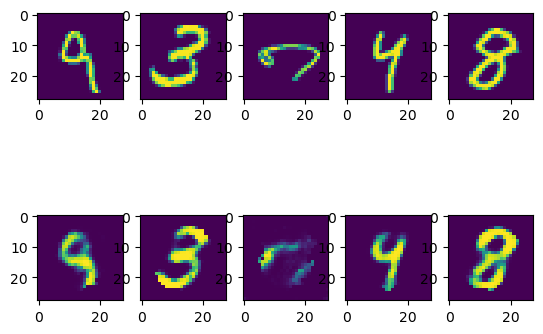

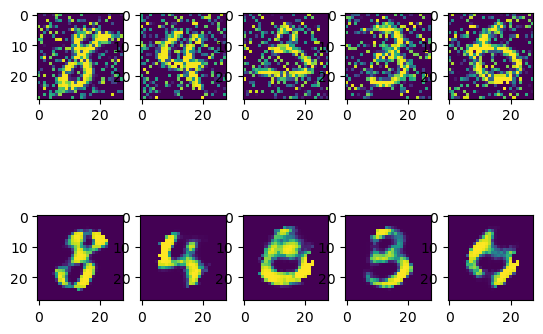

In [62]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
for i in range(1, 6):
        normal_image, reconstructed_normal_image = evaluate(normal_loader)
        fig.add_subplot(2, 5, i)
        plt.imshow(np.array(normal_image[0]).reshape(IMG_DIM, IMG_DIM))
        fig.add_subplot(2, 5, i+5)
        plt.imshow(np.array(reconstructed_normal_image[0]).reshape(IMG_DIM, IMG_DIM))

plt.savefig(f"SSIM_normal_reconstruction_MNIST_noise_lvl_{'03'}_corrupt_train_data")
plt.show()
plt.close()

fig = plt.figure()
for i in range(1, 6):
        anomaly_image, reconstructed_anomaly_image = evaluate(anomaly_loader)
        fig.add_subplot(2, 5, i)
        plt.imshow(np.array(anomaly_image[0]).reshape(IMG_DIM, IMG_DIM))
        fig.add_subplot(2, 5, i+5)
        plt.imshow(np.array(reconstructed_anomaly_image[0]).reshape(IMG_DIM, IMG_DIM))

plt.savefig(f"SSIM_anomaly_reconstruction_MNIST_noise_lvl_{'03'}_corrupt_train_data")
plt.show()
plt.close()
